# Load the data

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp

# from scipy.special import erfinv
from scipy.stats import norm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

%matplotlib inline

import matplotlib.pyplot as plt

In [ ]:
data_train_raw = pd.read_csv('../input/train.csv')
# data_train_raw = data_train_raw.sample(frac=0.01, random_state=0)
data_test_raw = pd.read_csv('../input/test.csv')

In [ ]:
data_train_raw.shape

# Data EDA and Transformation

In [4]:
def lossRescale(logloss,ymean,ystd):
    loss = (logloss-ymean)/ystd
    return loss
def lossRestore(logloss, ymean, ystd):
    loss = np.exp(logloss*ystd+ymean)
    return loss

In [5]:
shift=0
colLabel = 'logloss'
colRawLabel = 'loss'
labelColumns = [colLabel, colRawLabel]
data_train_raw[colLabel]=np.log(data_train_raw[colRawLabel]+shift)

In [6]:
# ymean=0
# ystd=1
ymean=data_train_raw[colLabel].min()
ystd=(data_train_raw[colLabel]-ymean).max()
data_train_raw[colLabel]=lossRescale(data_train_raw[colLabel],ymean,ystd)

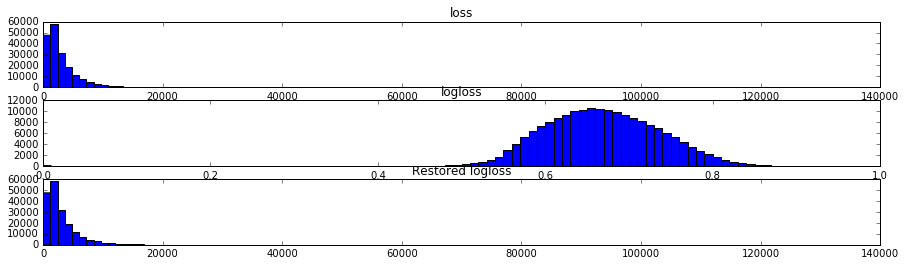

In [7]:
plt.figure(figsize=(15,4))

plt.subplot(3,1,1)
plt.hist(data_train_raw[colRawLabel],100)
plt.title(colRawLabel);
plt.subplot(3,1,2)
plt.hist(data_train_raw[colLabel],100)
plt.title(colLabel);
plt.subplot(3,1,3)
plt.hist(lossRestore(data_train_raw[colLabel],ymean,ystd),100)
plt.title('Restored '+colLabel);

In [8]:
print('Are there any null values?')
print(data_train_raw.isnull().any().any())
print(data_test_raw.isnull().any().any())

Are there any null values?
False
False


In [9]:
print('Logarithmic transformed loss:')
data_train_raw[colLabel].describe()

Logarithmic transformed loss:


count    188318.000000
mean          0.668016
std           0.067074
min           0.000000
25%           0.619150
50%           0.665687
75%           0.715454
max           1.000000
Name: logloss, dtype: float64

# Data preparation - labeling cat features with ordinal information encoded

In [10]:
# save label in a seperate serie
labelSs = data_train_raw[colLabel]
labelColumns.append('id')
trainDf = data_train_raw.drop(labelColumns,axis=1)
subId = data_test_raw['id']
testDf = data_test_raw.drop(['id'],axis=1)

print('trainDf has {} features from the raw data:\n{}'.format(len(trainDf), trainDf.columns))
print('testDf has {} features from the raw data:\n{}'.format(len(testDf),testDf.columns))

trainDf has 188318 features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)
testDf has 125546 features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)


In [11]:
dataAll = pd.concat([trainDf,testDf])
dataCatAll = dataAll.select_dtypes(include=['object'])
dataFltAll = dataAll.select_dtypes(include=['float64'])
print('the stacked data\'s dimension are:\n{}'.format(dataAll.shape))
print('{} of which are categorical'.format(dataCatAll.shape))
print('{} of which are continuous'.format(dataFltAll.shape))

the stacked data's dimension are:
(313864, 130)
(313864, 116) of which are categorical
(313864, 14) of which are continuous


In [12]:
dataCatAll.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,A,B,A,B,A,A,A,A,B,A,...,J,G,BU,BC,C,AS,S,A,O,LB
1,A,B,A,A,A,A,A,A,B,B,...,K,K,BI,CQ,A,AV,BM,A,O,DP
2,A,B,A,A,B,A,A,A,B,B,...,F,A,AB,DK,A,C,AF,A,I,GK
3,B,B,A,B,A,A,A,A,B,A,...,K,K,BI,CS,C,N,AE,A,O,DJ
4,A,B,A,B,A,A,A,A,B,B,...,G,B,H,C,C,Y,BM,A,K,CK


In [13]:
LevelList = {'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'}
# def LetterRep(x,LevelList):
#     if x in LevelList:
#         x = '0'+x
#     return x
    
def LetterRep(x,LevelList):
    if x in LevelList:
        x = '0'+x
    return x

dataCatAll = dataCatAll.applymap(lambda x: LetterRep(x,LevelList))
dataCatAll.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,0A,0B,0A,0B,0A,0A,0A,0A,0B,0A,...,0J,0G,BU,BC,0C,AS,0S,0A,0O,LB
1,0A,0B,0A,0A,0A,0A,0A,0A,0B,0B,...,0K,0K,BI,CQ,0A,AV,BM,0A,0O,DP
2,0A,0B,0A,0A,0B,0A,0A,0A,0B,0B,...,0F,0A,AB,DK,0A,0C,AF,0A,0I,GK
3,0B,0B,0A,0B,0A,0A,0A,0A,0B,0A,...,0K,0K,BI,CS,0C,0N,AE,0A,0O,DJ
4,0A,0B,0A,0B,0A,0A,0A,0A,0B,0B,...,0G,0B,0H,0C,0C,0Y,BM,0A,0K,CK


In [14]:
features = dataCatAll.columns[0:]
cats = [feature for feature in features if feature.startswith('cat')]
for feat in cats:
    dataCatAll[feat] = pd.factorize(dataCatAll[feat], sort=True)[0]
dataCatAll.head()
# le.classes_

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,0,1,0,1,0,0,0,0,1,0,...,9,6,68,49,2,43,17,0,14,301
1,0,1,0,0,0,0,0,0,1,1,...,10,10,56,87,0,46,60,0,14,115
2,0,1,0,0,1,0,0,0,1,1,...,5,0,25,106,0,2,28,0,8,185
3,1,1,0,1,0,0,0,0,1,0,...,10,10,56,89,2,13,27,0,14,109
4,0,1,0,1,0,0,0,0,1,1,...,6,1,7,2,2,24,60,0,10,85


In [15]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()

# for col in dataCatAll.columns:
#     if (col.find('cat') !=-1):
#         dataCatAll[col]=le.fit_transform(dataCatAll[col])
# print(dataCatAll.columns)


In [16]:
# dataCatAll.head()

In [17]:
# rescale the labeled categorical data
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
x_catAll = mms.fit_transform(dataCatAll)

In [18]:
print(x_catAll.shape)
x_catAll

(313864, 116)


array([[ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.63636364,  0.86494253],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.63636364,  0.33045977],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.36363636,  0.5316092 ],
       ..., 
       [ 1.        ,  1.        ,  0.        , ...,  0.        ,
         0.68181818,  0.93103448],
       [ 0.        ,  0.        ,  0.        , ...,  0.22222222,
         0.63636364,  0.31321839],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.5       ,  0.26436782]])

# one-hot-encoding - skipped in order to keep the alphabetical order

In [19]:
# # one-hot-encoding the categorical features
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder()
# x_catAll = enc.fit_transform(dataCatAll)
# print(x_catAll.shape)

# split x_train and x_test

In [20]:
# split x_train and x_test
x_train = sp.sparse.hstack((x_catAll[0:len(labelSs),:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[0:len(labelSs),:]))
x_test = sp.sparse.hstack((x_catAll[len(labelSs):,:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[len(labelSs):,:]))
y_train = labelSs.values

# check the dimension of prepared data

In [21]:
print(x_test.shape)
print(x_train.shape)
print(y_train.shape)

(125546, 130)
(188318, 130)
(188318,)


# splite the training data for valication

In [22]:
from sklearn import cross_validation
val_size = 0.2
seed = 0
x_train, x_val, y_train, y_val = cross_validation.train_test_split(x_train, y_train, test_size=val_size, random_state=seed)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(150654, 130)
(150654,)
(37664, 130)
(37664,)


In [23]:
# del x_Train
# del y_Train
# del x_catAll
# del dataCatAll
# del trainDf
# del testDf

# Model Fitting

In [24]:
from sklearn.metrics import mean_absolute_error
y_pred = []
y_pred_val = []
submission = pd.read_csv('../input/sample_submission.csv')

In [25]:
testList = ['XGBoostTrees']

### XGBoost Trees

In [26]:
def logregobj(preds, dtrain):
    labels = dtrain.get_label()
    con = 2
    x =preds-labels
    grad =con*x / (np.abs(x)+con)
    hess =con**2 / (np.abs(x)+con)**2
    return grad, hess 

# def evalerror(preds, dtrain):
#     labels = dtrain.get_label()
#     return 'mae', mean_absolute_error(np.exp(preds), np.exp(labels))
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'mae', mean_absolute_error(preds, labels)

In [27]:
import xgboost as xgb
# from sklearn.grid_search import GridSearchCV

In [28]:
d_train_xgb = xgb.DMatrix(x_train.tocsc(),label=y_train)
d_val_xgb = xgb.DMatrix(x_val.tocsc(),label = y_val)
x_val_xgb = xgb.DMatrix(x_val.tocsc())
d_test_xgb = xgb.DMatrix(x_test.tocsc())

In [29]:
# params = { 'max_depth': [4, 6, 10], 'min_child_weight':[0,1,2], 'gamma':[0,1,2], \
#            'subsample':[0.5,0.8,1], 'colsample_bytree':[0,1,2], \
#            'eval_metric': 'mae'
#            }
# num_round = 500
# xgbt = GridSearchCV(xgb.XGBRegressor, )

In [30]:
num_round = 3000

# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
#           'eta':0.05,'min_child_weight':0,'subsample':0.8}# 1187, default RMSE obj function
params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
          'eta':0.02,'min_child_weight':0,'subsample':0.8}# 1140.25, customized MAE obj function, log, rescale

watchlist  = [(d_val_xgb,'eval'), (d_train_xgb,'train')]
gbt = xgb.train(params, d_train_xgb,num_round,watchlist, obj=logregobj, early_stopping_rounds=300)
# gbt = xgb.train(params, d_train_xgb, num_round, watchlist, early_stopping_rounds=300)

[0]	eval-mae:0.164771	train-mae:0.164612
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 300 rounds.
[1]	eval-mae:0.16126	train-mae:0.161094
[2]	eval-mae:0.157836	train-mae:0.157664
[3]	eval-mae:0.154493	train-mae:0.154319
[4]	eval-mae:0.151233	train-mae:0.151055
[5]	eval-mae:0.148051	train-mae:0.14787
[6]	eval-mae:0.144947	train-mae:0.14476
[7]	eval-mae:0.141913	train-mae:0.141722
[8]	eval-mae:0.138956	train-mae:0.138761
[9]	eval-mae:0.136072	train-mae:0.135871
[10]	eval-mae:0.133257	train-mae:0.133051
[11]	eval-mae:0.130511	train-mae:0.1303
[12]	eval-mae:0.127832	train-mae:0.127616
[13]	eval-mae:0.125217	train-mae:0.125
[14]	eval-mae:0.122671	train-mae:0.122451
[15]	eval-mae:0.120189	train-mae:0.119964
[16]	eval-mae:0.117769	train-mae:0.117538
[17]	eval-mae:0.115411	train-mae:0.115175
[18]	eval-mae:0.113113	train-mae:0.11287
[19]	eval-mae:0.110875	train-mae:0.110622
[20]	eval-mae:0.10869	train-mae:0.1

In [32]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(gbt.predict(x_val_xgb),ymean,ystd)))
# print(mean_absolute_error(y_val,gbt.predict(x_val_xgb)))

1140.25792284


In [ ]:
fig = plt.figure(figsize=(20,35))

xgb.plot_importance(gbt,ax = fig.gca() );

In [ ]:
y_pred_i = gbt.predict(d_test_xgb)
y_pred.append(lossRestore(y_pred_i,ymean,ystd))
y_pred_val.append(lossRestore(gbt.predict(x_val_xgb),ymean,ystd))

# save files for submission

In [ ]:
# # remove the shift
# y_pred = [y_array-shift for y_array in y_pred];
# y_pred_val_en = [y_array-shift for y_array in y_pred_val_en];

In [ ]:
# Save all the predictions for submission
for i,stri in enumerate(testList):
    submission['id'] = subId
    submission['loss']=pd.Series(data=y_pred[i])
    submission.to_csv('../output/'+stri+'.csv',index=False)

In [ ]:
from sklearn.externals import joblib
joblib.dump([gbt, y_pred, y_pred_val, x_train, x_val, y_train, y_val, x_Test]
            ,'../output/models-raw-features-rescale-loss-shift.pkl',compress=3) 

# clf = joblib.load('filename.pkl') 

In [ ]:
testList
